### Table of Contents

* [Introduction](#chapter1)
* [Experimental setup](#chapter2)
    * [Preliminaries](#Section_2_1)
    * [Preprocessing](#Section_2_2)
* [Method](#chapter3)
    * [Rolling window](#section_3_1)
    * [Zero crossing](#section_3_2)
    * [TF-IDF and LDA](#section_3_3)
* [Results](#chapter4)
    * [LDA](#section_4_1)
    * [Rule-based](#section_4_2)
* [Evaluation](#chapter5)
* [Conclusion](#chapter6)
* [Discussion](#chapter7)

## Introduction <a class="anchor" id="chapter1"></a>

Nowadays we see the implementation of data analysis on almost every level. It is important to different companies, researchers, governments and so on. However there are still fields that are not so compatible with data analysis, such as politics. Politics is not based on numbers or labels. Politics base lies in the people affiliated with it and their communication between eachother. This means to describe it we can not always turn to our standard numerical data and have to avert to Natural Language Processing or NLP. With the help of NLP we can get a clearer sense what is happening in our politic landscape and get a better understanding who we could count on. 

The Dutch parliament is chosen in a parliamentaric democratic manner. This means that there are many parties with a lot of different views. This still does not mean that the biggest party would rule on its own, but that they have to form a coalition with other parties to reach a majority of the seats in the house of representatives. In this process the parties that want to be part of this coalition will meet with eachother and try to compromise until they can agree that they could work together to rule the Netherlands. This means that many of point of their program during the campaign will never make it in effect. 
With half of the pandemic behind us and people having to suffer some loss of freedom in order to preserve the health of the country, they are eager to vote so their voice is represented in the upcoming parliament. The problem is that many people do not know for which party to vote, also because many of the campaign gets lost when forming a coalition.

Therefore it would be useful to get a more clear idea of parties their preferences and opinions while already in the house of representatives and to find the right information about how the parties approach different topics in practice. Luckily CLARIN, a distributed digital infrastructure with participants from different European institutes, had roughly the same idea on a continental scale. It started their ParlaMint project that aims to provide is a verified communication channel between the elected political representatives and society members in any democracy. Their mission in the ParlaMint project is to  turn multilingual and diverse parliamentary data into coparable and interpretable resources. 

With upcoming elections in mind this notebook, aims to show how NLP can be used to provide information about the Dutch political landscape. Especially regarding the parties that were included in the house of representatives. With 4 different research questions we hope to provide an extensive overview of sentiment, topics and framing.

To get a more clear view in what parties hold as holy and on what kind of subjects they are willing to compromise with forming a coalition, it would be useful to see where parties disagree and agree in practice. A way to research this would be to find issues where parties respond sentimentally in regards to eachother. By looking at periods where parties would be more positive or negative towards eachother and see what the most spoken subject of the time was. Therefore one of the research questions will sound: *What are the topics where parties would speak with a positive or negative sentiment about eachother before and during the pandemic?*

## Description of data

The data was provided by [CLARIN](https://www.clarin.eu/) in cooperation with the University of Amsterdam. CLARIN hosts a project called [ParlaMint](https://www.clarin.eu/content/parlamint-towards-comparable-parliamentary-corpora) with contributing institutes around Europe. The ParlaMint project provided us a dataset with transcripts from the dutch parliament. This entails transcripts from the house of representatives and the senate from 06-04-2014 until 03-11-2020. These transcripts are given in XML files where the tags and their different attributes are useful for extra information about the utterances in the data. The data also came with a meta-data file containing all the information needed about the different speakers who made such utterances in either the house of representatives or the senate. The meta-data file holds the information of 493 different speakers annotated with party, gender, and time active in the parliament. The amount of parties included in the data is 28.

## RQ - 2

The third research question was: *What are the topics where parties would speak with a positive or negative sentiment about eachother before and during the pandemic?*

This notebook tries to handle the question in following manner. 
At first the notebook pre-proccesses the data in a way that no information about person, party or date gets lost. After this preprocessing is done it will seek for a main line within the data. After transformation it will find the positive and negative periods and store these to find any sentiment in these periods. When it gets a clear view of positive and negative sentiments it can search for the topics behind the positive and negative sentiment, respectively.

In this way the notebook hopes to provide an overview on how parties handles other parties their opinions. Either with positive or negative notions it hopes to give more information on different topics within the parliament and between the parties accordingly. 

**Related literature**

Sentiment analysis is a favorable type of text mining for different NLP tasks. There are different type of sentiment analysis. The most common one is working with a lexicon of annotated words. These words carry a sentiment and annotated by people based on being either positive or negative. Calculate this with the amount of times a positive or negative word comes up in accordance with the length of an utterance and it will return a sentiment score. There is also the possibility of using sentiment analysis based on fragments. When annotating sentiment at fragments of speech and using machine learning to handle these fragments research found to have a better method of analysis (Kanayama, 2004).

Latent Dirichlet Analysis is a method for topic analysis and is used a lot to get a clear and fast overview on what topics to expect within a document. However LDA may not be the best for human interpretation. As it returns keywords instead of topics and could alter every time being used. However LDA is one of the foremost in machine learning to get topics for a big corpus (Song, 2009)

## Experimental setup <a class="anchor" id="chapter2"></a>

**Preliminaries** <a id="Section_2_1"></a>

The notebook depends on different libraries for either pre-processing, transformations and visualization. Extracting the data from the provided XML files relies on XMLTree. To pre-process the data their will be implementations of NLTK and Regex packages. For sentiment analysis the package pattern is used, a version of pattern that is in Dutch to be more precise. At last we use the library of gensim for topic-analysis.

In [1]:
import xml.etree.ElementTree as ET
import os
from pattern.nl import sentiment
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import operator
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
import pandas as pd
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from datetime import date
import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel
from gensim import models
from nltk.corpus import wordnet
from pattern.nl import pluralize
nltk.download('wordnet')
nltk.download('omw')

[nltk_data] Downloading package stopwords to /home/marten/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/marten/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw to /home/marten/nltk_data...
[nltk_data]   Package omw is already up-to-date!


True

**Data Preprocessing**<a id='Section_2_2'></a>

The data provided is as stated above from the CLARIN ParlaMint project. To take every important piece of data into account a class will be used to include what is said, the party that does the utterance, the date it is said and the speaker behind the utterance.

<img src="Data Preprocces.png" width='600'>

In [2]:
class Segment:
    def __init__(self, seg=None, party=None, time=None, speaker=None):
        self.seg=seg
        self.party = party
        self.time = time
        self.speaker = speaker

To use this class called Segment we first need to extract the political parties that a speaker is affiliated with to denote this in the attribute. In the meta-data file a list of speakers and their parties are denoted. For every time someone was a chair this will not be denoted in the class, because in this case the person who was chair would be indifferent towards the parties. 
From the meta-data file the notebook wil make a dictionairy containing names and parties to use this in the class segment later on. After this part the notebook extracts the data from the xml files. Here we use a list to store all the different class objects. These class objects will be given a date, speaker, party and the utterance they made.

In [3]:
# for the meta-data file ParlaMint-NL.xml
# this function makes a dictionairy with as key the name of the politicin and as value his or her party

# Parsing a tree from the meta-data xml file
tree = ET.parse("ParlaMint-NL/full_dataset_output_second_pass_16_01/ParlaMint-NL.xml")
# Finding the root node so we can iterate through and find other children
root = tree.getroot()
# Denoting dictionairy for their parties and members
namen = {}
# Finding the tags that contains the names of the possible party members and their party respectively
for j in root.iter('{http://www.tei-c.org/ns/1.0}person'):
    # Each 'j' in the loop is now denoting a person
    # In the id attribute of the person tag we find the name of the member
    naam = j.attrib['{http://www.w3.org/XML/1998/namespace}id']
    # Use a try and except because some of the names in the file do not have a party
    try:
        # Find the affiliation attribute for their party 
        partij = j.find('{http://www.tei-c.org/ns/1.0}affiliation').attrib['ref'][7:]
    except AttributeError:
        partij = None
    except KeyError:
        partij = 'Chair'
    # Add to the dictionairy
    namen[naam] = partij
    
# Example:
namen['SigridKaag']

'D66'

In [4]:
directory = os.listdir('ParlaMint-NL/full_dataset_output_second_pass_16_01')
# Iterate through folder with the data files and make a list for all things said
segs = []
# Sort the folder to keep dates in order
for i in sorted(directory):
    # Skip meta-data file
    if i == 'ParlaMint-NL.xml':
        continue
    # Join name of file and folder
    i = os.path.join('ParlaMint-NL/full_dataset_output_second_pass_16_01', i)
    # Parse tree within file
    tree = ET.parse(i)
    # Find root node of tree
    root = tree.getroot()
    # Iterate through tree finding dates 
    for tijd in root.iter('{http://www.tei-c.org/ns/1.0}date'):
        tijd = tijd.text
        
    # In the u tag there are the leafes that hold the transcripts
    for text in root.iter('{http://www.tei-c.org/ns/1.0}u'):
        # Filter out everything said by a chair
        if text.attrib['ana'] == '#chair':
            continue
        # Use find all because some utterances are split within the u leaf
        temp = []
        for seg in text.findall('{http://www.tei-c.org/ns/1.0}seg'):
            temp.append(seg.text)
        segs.append(Segment(temp, namen[text.attrib['who'][1:]], tijd, text.attrib['who'][1:]))
        
# Example:
print(segs[0].time)
print(segs[0].speaker)
print(segs[0].party)
print(segs[0].seg)

2014-04-16
FleurAgema
PVV
['Voorzitter. Ik dien de volgende motie in.']


To get some clearity about the data the notebook will find the utterances where the name of another party is used for all the texts of another party. In the compare function it iterates through all utterances, when it finds the party the user wants to explore it will go on to store the utterances where they used the name of the other party. It stores them into two lists, one for the sentiment values and one for the time values. The sentiment value of an utterance is calculated with the library [pattern](https://github.com/clips/pattern). Pattern is a web mining module for python that includes a tool for NLP, namely 'sentiment'. With the help of the University of Twente they expanded the tool so that it is also capable to annotate dutch utterances using [pattern.nl](https://research.utwente.nl/en/publications/improving-patternnl-sentiment-analysis). This tool has 6877 unique words annotated with different sentiments. With this data the notebook is able to provide the first plots to give a sense of what type of utterances we are dealing with. 

In [5]:
def compare(party1, party2):
    # Lists for the plot later on
    y = []
    x = []
    wat = []
    # Iterate through the list with class objects
    for i in segs:
        # Find the utterances done by the party one
        if i.party == party1:
            # Try except because some of the utterances were empty and contained nothing
            try:
                # For all the utterances, sometimes it could be more than one in the u leaf as stated above
                for j in range(len(i.seg)):
                    # Check wether the utterance contains the name of the other party
                    if party2 in i.seg[j]:
                        # Store these utterances, sentiment and date in new lists
                        wat.append(i.seg[j])
                        y.append(sentiment(i.seg[j])[0])
                        x.append(i.time)
            except TypeError:
                continue
                
    # Find the date closest to the first Covid debate 
    for k in x:
        if k[:-1] == '2019-10-0':
            cov = x.index(k)
            break

            
    return x, y, cov

With a scatter plot and using sklearns polynomal regression the notebook aims to find a underlying line in the data. This could give more sense in the periods of time where these parties could be more positive or negative about eachother. To find the best parameter for the amount of polynomal features the notebook uses Random Mean Squared Error. It checks at which k this value is the lowest and eventually shows the plot with this k as polynomal features. With this line we can get a more descriptive graph of the data.

k = 7
0.18399967064250217


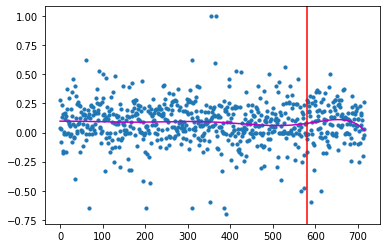

In [6]:
def poly(party1, party2):
    rmse = []
    comp = compare(party1, party2)
    y = comp[1]
    x = np.array([i for i in range(len(y))]).reshape(-1,1)
    for j in range(0,40):
        polynomial_features= PolynomialFeatures(degree=j)
        x_poly = polynomial_features.fit_transform(x)
        model = LinearRegression()
        model.fit(x_poly, y)
        y_poly_pred = model.predict(x_poly)
        rmse.append(np.sqrt(mean_squared_error(y,y_poly_pred)))

    print('k =', rmse.index(min(rmse)))
    print(min(rmse))


    polynomial_features= PolynomialFeatures(degree=rmse.index(min(rmse)))
    x_poly = polynomial_features.fit_transform(x)

    model = LinearRegression()
    model.fit(x_poly, y)
    y_poly_pred = model.predict(x_poly)
    plt.scatter(x, y, s=10)
    sort_axis = operator.itemgetter(0)
    sorted_zip = sorted(zip(x,y_poly_pred), key=sort_axis)
    x, y_poly_pred = zip(*sorted_zip)
    plt.plot(x, y_poly_pred, color='m')
    plt.axvline(comp[2], color='r')
    plt.show()
    
# Example:
poly("VVD", "GroenLinks")

To see some general statistics the notebook provides a dataframe with the mean, minimum, maximum and standard deviation of the sentiment values. It does this for all the data, before the pandemic and during the pandemic to give some insight in changes between the parties around the covid outbreak. From a function that makes series with each of the previously named periods, it gets combined in the next function to one dataframe.

In [7]:
def serie(party1, party2, cov=0):
    if cov == 0:
        comp = compare(party1, party2)[1]
    elif cov == 1: 
        comp = compare(party1, party2)[1][compare(party1, party2)[2]:-1]
    else:
        comp = compare(party1, party2)[1][0:compare(party1, party2)[2]]
    minimum = min(comp)
    maximum = max(comp)
    mean = np.mean(comp)
    std = np.std(comp)

    return pd.Series([minimum, maximum, mean, std], index=['minimum', 'maximum', 'mean', 'std'])

In [8]:
def dataframe(party1, party2):
    alles = serie(party1, party2, 0)
    precovid = serie(party1, party2, 2)
    covid = serie(party1, party2, 1)
    
    return pd.DataFrame({'all data': alles,'pre-covid':precovid, 'covid':covid})

# Example:
dataframe("FvD", "PVV")

,all data,pre-covid,covid
minimum,-0.212500,-0.185972,-0.212500
maximum,0.430000,0.430000,0.249524
mean,0.045237,0.052724,0.038175
std,0.140938,0.174041,0.119999


## Method<a id='chapter3'></a>

**Rolling window**<a id='section_3_1'></a>

Now that the notebook provided some general plots and statistics of the data it transforms the data. The data will be transformed using a rolling window of the time series to give stability to the data over the utterances their sentiment. The rolling window takes the mean over 30 days and uses this as one data point. In this way all the utterances and their sentiment within one month will be averaged and stored. <img src='rollingwindow.png' width='400'>  

In [9]:
def roller(party1, party2):
    # Get the utterances where parties talk about eachother
    a = compare(party1, party2)
    # Get the dates from the utterances
    index = a[0]
    # Get the sentiment values of the utterances
    values = a[1]
    # Get the index of the date for the first debate during covid
    cov = index[a[2]]
    # Make a dataframe of the sentiment values with date as index
    df = pd.DataFrame(data={'Sentiment':values}, index=pd.to_datetime(index))
    # Return a rolling window over 30 days with method mean and the date of the first covid debate
    return df.rolling(window='30d').mean(), date(int(cov[0:4]), int(cov[5:7]), int(cov[8:10]))

# Example:
roller('VVD', 'D66')[0].head()

,Sentiment
2014-04-16,0.040000
2014-12-09,0.235185
2014-12-09,0.142593
2014-12-09,0.121332
2014-12-11,0.158332


To use the utterances behind the sentiment score for topic analysis we need to process the strings. Therefore the notebook needs to delete some stopwords. For the collection of stopwords the notebook uses a text file containing over 300 words. 

In [10]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    # Open text files with stopwords
    a_file = open("stopwords.txt", "r")
    stop_words = []
    for line in a_file:
        # Strip whitelines from text line
        stripped_line = line.strip()
        # Store stopword in string in list
        stop_words.append(stripped_line)
    a_file.close()
    # Return input string without stopwords
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

To help and find the topic of a utterances the notebook has the topic function. In the topic function the notebook searches for the relevant utterances and their dates. When it finds all utterances from a specified party about one other party it stems them using the [snowball stemmer from the NLTK library](https://www.nltk.org/_modules/nltk/stem/snowball.html), this stemmer has a dutch implementation. The function also accepts a covid variable specifying in which periode of time we are interested. After this process it returns the stemmed utterances within the specified dates.

In [11]:
def topic(party1, party2, van, tot, cov=0):
    wat = []
    x = []
    stemmer = SnowballStemmer("dutch")
    for i in segs:
        if i.party == party1:
            try:
                for j in range(len(i.seg)):
                    if party2 in i.seg[j]:
                        wat.append(i.seg[j])
                        x.append(date(int(i.time[0:4]), int(i.time[5:7]),int(i.time[8:10])))
            except TypeError:
                continue

    van = x.index(van)
    tot = x.index(tot)
    if cov == 1:
        wat = wat[x.index(roller(party1, party2)[1]):]
    elif cov == 2:
        wat = wat[:x.index(roller(party1, party2)[1])] 
    

    all_text = []
    for i in wat[van:tot]:
        i = re.sub('[,\.!?]', '', i)
        i = i.lower()
        i = stemmer.stem(i)


        all_text.append(i)
        
    all_text = remove_stopwords(list(sent_to_words(all_text)))
    return all_text


**Zero-crossing**<a id='section_3_2'></a>

To establish in which periods of time the parties were more positive or negative about eachother the notebook has a function to check where the plot crosses the zero line. Whenever it crosses the line it stores the index to mark the dates in which between there are negative and positive sentiments. These indices can be used in the topic function to retrieve the utterance from these areas above and under zero. <img src='zerocrossing.png' width='500'>

In [12]:
def zerocrosser(party1, party2):
    a = roller(party1, party2)
    if a[0]['Sentiment'].tolist()[0] > 0:
        k = 1
    else:
        k = -1
    zero_crossings = np.where(np.diff(np.sign(a[0]['Sentiment'].tolist())))[0]
    index = a[0].index
    ret = []
    for i in zero_crossings:
        ret.append(index[i])
    return ret, k

**TF-IDF and LDA**<a id='section_3_3'></a>

In the function all topics the notebook uses the indices from zerocrosser function and the utterance retrieving of the  topic function to get the utterances within the positive and negative areas and combine them within lists to make to store them for later use. It also stores all utterances, either positive or negative to create a corpus of all the utterances made between specified party one and two. From this corpus the notebook also creates a dictionary without words that occur no more than 2 times within the corpus. The corpus then gets transformed using a TF IDF function. This gives weights to certain words and their documents. 
With term frequency as:
$${tf} (t,d)={\frac {f_{t,d}}{\sum _{t'\in d}{f_{t',d}}}}$$
The inverse document frequency as:
$${idf} (t, D) =  \log \frac{N}{|\{d \in D: t \in d\}|}$$
Combined to form the TF IDF:
$$ {tfidf} (t,d,D)={tf} (t,d)\cdot \mathrm {idf} (t,D)$$
Where t denotes term, d denotes document and D denotes the set of documents.

With this dictionairy and corpus the notebook uses the [Gensim](https://radimrehurek.com/gensim/) library to preform a Latent Dirichlet Allocation (LDA) topic analysis. LDA builds a topic per document model and words per topic model. These are modeled as Dirichlet distirbutions. Where Dirichlet distrutions entail the conjugate prior of the categorical distribution and multinomial distribution. The Gensim tool trains the LDA model to find keywords around the different utterances stored in the corpus. If the notebook specifies an utterance within the corpus, it will return an amount of keywords for each topic within the corpus and calculates the probability of the utterance correlating to one of these topics.

In [13]:
def all_topics(party1, party2, cov=0):
    ind = zerocrosser(party1, party2)[0]        
    pos = []
    neg = []
    all_text = []
    for i in range(len(ind)-1):
        a = topic(party1, party2, ind[i], ind[i+1], cov)
        if a == None:
            continue
        if i % 2 != 0:
            pos.extend(a)
        else:
            neg.extend(a)
        all_text.append(a)
    checker = []
    all_text = remove_stopwords(list(sent_to_words(all_text)))
    id2word = corpora.Dictionary(all_text)
    id2word.filter_extremes(no_below=2)
    corpus = [id2word.doc2bow(text) for text in all_text]
    tfidf = models.TfidfModel(corpus)
    corpus = tfidf[corpus]
    for k in range(2,15):
        lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=k)
        cm = CoherenceModel(model=lda_model, corpus=corpus, texts=all_text, coherence='c_v')
        checker.append(cm.get_coherence()) 
                
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=checker.index(max(checker))+2)
    print(max(checker))
            
    return lda_model, corpus, checker.index(max(checker))+2, max(checker), pos, neg

To combine all the techniques used above the notebook has a function called *alles*. This function will ask for two parties that we are interested in and returns the general statisctics, the rolling window plot with a red vertical line denoting the start of debate about Covid and the most probable topics' their keywords within different periods. These keywords are found in the all topics function with the use of the LDA-analysis. It calculates the overall probability of topics being related with the negative or positive sentiment overall. When this probability is above 0.5 it prints the numbers of their topics and their key words. 

In [14]:
def alles(party1, party2):
    print(party1+ ' over '+ party2)
    print('General statistics:')
    print('\n')
    print(dataframe(party1, party2))
    print('\n')
    plt.plot(roller('VVD', 'GroenLinks')[0])
    plt.axvline(x=roller('VVD', 'GroenLinks')[1], color='r')
    print("Mean sentiment after rolling window of 30 days: "+ str(np.mean(roller('VVD', 'GroenLinks')[0]['Sentiment'].tolist())))  
    print('Graph using rolling window of 30 days:')
    plt.plot(roller(party1, party2)[0])
    plt.axvline(x=roller(party1, party2)[1], color='r')
    plt.show()
    
    for i in range(3):
        if i == 0:
            print('All Data')
        elif i == 1:
            print('Before Covid')
        else:
            print('During Covid')
        all_tops = all_topics(party1, party2, i)
        print('\n')
        topicspos = []
        topicsneg = []
    
        for i in range(len(all_tops[1])):
            if i % 2 == 0:
                topicspos.append(all_tops[0][all_tops[1][i]])
            else:
                topicsneg.append(all_tops[0][all_tops[1][i]])
            
        if zerocrosser(party1, party2)[1] < 0:
            topicspos, topicsneg = topicsneg, topicspos
        
        
        pos = {}
        neg = {}

        for i in topicspos:
            for j in i:
                if j[0] in pos.keys():
                    pos[j[0]].append(j[1])
                else:
                    pos[j[0]] = [j[1]]
            
        for i in topicsneg:
            for j in i:
                if j[0] in neg.keys():
                    neg[j[0]].append(j[1])
                else:
                    neg[j[0]] = [j[1]]
        

        print('{} topics with a coherence value of {}'.format(all_tops[2], all_tops[3]))   
        interestingtopics = []
        print("Positive topics with a probability of >0.5:")
        a = 0
        for k in pos.keys():
            if len(pos[k]) == 0:
                continue
            if sum(pos[k])/len(pos[k]) > 0.5:
                interestingtopics.append(k)
                print(k, ' : ', sum(pos[k])/len(pos[k]))
        print("Negative topics with a probability of >0.5:")
        for k in neg.keys():
            if len(neg[k]) == 0:
                continue
            if sum(neg[k])/len(neg[k]) > 0.5: 
                interestingtopics.append(k)
                print(k, ' : ', sum(neg[k])/len(neg[k]))

        for i,topic in all_tops[0].show_topics(formatted=True, num_topics=all_tops[2], num_words=20):
            if i in interestingtopics:
                print(str(i)+": "+ topic) 
                print()
        print('\n')

VVD over GroenLinks
General statistics:


         all data  pre-covid     covid
minimum -0.700000  -0.700000 -0.600000
maximum  1.000000   1.000000  0.500000
mean     0.085932   0.084474  0.092574
std      0.184584   0.188210  0.168783


Mean sentiment after rolling window of 30 days: 0.08508826949231355
Graph using rolling window of 30 days:


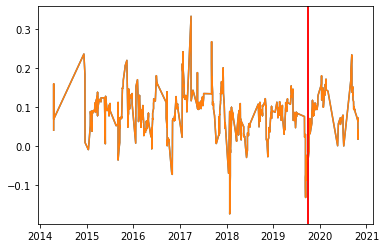

All Data
0.5357376235276795


5 topics with a coherence value of 0.5357376235276795
Positive topics with a probability of >0.5:
Negative topics with a probability of >0.5:
3  :  0.8864754835764567
3: 0.001*"afbouwen" + 0.001*"cijfers" + 0.001*"grashoff" + 0.001*"snel" + 0.001*"stel" + 0.001*"besef" + 0.001*"gasverbruik" + 0.001*"alternatief" + 0.001*"vorige" + 0.001*"beheersbaar" + 0.001*"komt" + 0.001*"landen" + 0.001*"amsterdam" + 0.001*"ermee" + 0.001*"klaver" + 0.001*"terecht" + 0.001*"voortgang" + 0.001*"analyse" + 0.001*"werkenden" + 0.001*"beantwoord"



Before Covid
0.40737533590529


4 topics with a coherence value of 0.40737533590529
Positive topics with a probability of >0.5:
Negative topics with a probability of >0.5:


During Covid
0.427266277924304


4 topics with a coherence value of 0.427266277924304
Positive topics with a probability of >0.5:
Negative topics with a probability of >0.5:
3  :  0.5252761929813359
3: 0.001*"afbouwen" + 0.001*"stel" + 0.001*"vorige" + 0.001

In [15]:
party1 = 'VVD'
party2 = 'GroenLinks'
alles(party1, party2)

With the LDA topic analysis the notebook does not return satisfying results every time. Notes about this will be found later on in the discussion. To ensure we get an overview of negative and positive sentiment between different parties the notebook has another topic analysis implementation that starts with another all topics function. This function works the same as the all topics function above, except it return the positive and negative utterances combined from the topic function above. It does not preform any computation on them, it just joins them together.

In [16]:
def all_topics_perc(party1, party2, cov=0):
    ind = zerocrosser(party1, party2)[0]        
    pos = []
    neg = []
    all_text = []
    for i in range(len(ind)-1):
        a = topic(party1, party2, ind[i], ind[i+1], cov)
        if a == None:
            continue
        if i % 2 != 0:
            pos.extend(a)
        else:
            neg.extend(a)
            
        if zerocrosser(party1, party2)[1] < 0:
            pos, neg = neg, pos
            
        
        all_text.append(a)

    all_text = remove_stopwords(list(sent_to_words(all_text)))
    
                
    return pos, neg, all_text

To determine the topic from different utterances the notebook aims to find words that are being used in these utterances that have an affiliation with one of the pre-determined topics. Therefore this approach will be rule-based and would not provide new topics that are not denoted within the notebook. In order to create a list with words affiliated to topics the notebook uses wordnet hyponyms and synonyms. [Wordnet](https://www.nltk.org/howto/wordnet.html) is part of NLTK in python and serves as a archive of word ethymology. The topics are pre-determined based on the information provided by the dutch [Rijks Overheid](https://www.rijksoverheid.nl/onderwerpen/veranderingen). Every year they provide a webpage with information about what will change in the next year according to new laws. They divide these laws in six topics:

Work and income

Health and healthcare

Family

Traffic and transport

Living

Corporate

In addition to these six topics we provided the notebook with some other prominent subjects the parliament discusses. These topics are:

Immigration

Foreign affairs

Education

Agriculture



In [17]:
def subjects():
    wordlst_economie = ['werk', 'inkomen']
    keywords_economie = ['werk', 'inkomen']
    wordlst_zorg = ['zorg', 'gezondheid']
    keywords_zorg = ['zorg', 'gezondheid']
    wordlst_familie = ['familie', 'gezin']
    keywords_familie = ['familie', 'gezin']
    wordlst_verkeer = ['verkeer', 'vervoer']
    keywords_verkeer = ['verkeer', 'vervoer']
    wordlst_wonen = ['wonen']
    keywords_wonen = ['wonen']
    wordlst_ondernemen = ['ondernemen']
    keywords_ondernemen = ['ondernemen']
    wordlst_immigratie = ['immigratie', 'vluchtelingen']
    keywords_immigratie = ['immigratie', 'vluchtelingen']
    wordlst_buitenland = ['Europa', 'buitenland']
    keywords_buitenland = ['Europa', 'buitenland']
    wordlst_onderwijs = ['onderwijs', 'jongeren']
    keywords_onderwijs = ['onderwijs', 'jongeren']
    wordlst_landbouw = ['boeren', 'landbouw']
    keywords_landbouw = ['boeren', 'landbouw']

    for word in keywords_economie:
        wordlst_economie.append(pluralize(word))
        syns = wordnet.synsets(word, lang='nld')
        for i in range (len(syns)):
            for j in range (len(syns[i].lemmas(lang='nld'))):
                if syns[i].lemmas(lang='nld')[j].name() not in wordlst_economie:
                    wordlst_economie.append(syns[i].lemmas(lang='nld')[j].name())
                    wordlst_economie.append(pluralize(syns[i].lemmas(lang='nld')[j].name()))
                    
    for word in keywords_zorg:
        wordlst_zorg.append(pluralize(word))
        syns = wordnet.synsets(word, lang='nld')
        for i in range (len(syns)):
            for j in range (len(syns[i].lemmas(lang='nld'))):
                if syns[i].lemmas(lang='nld')[j].name() not in wordlst_zorg:
                    wordlst_zorg.append(syns[i].lemmas(lang='nld')[j].name())
                    wordlst_zorg.append(pluralize(syns[i].lemmas(lang='nld')[j].name()))
                    
    for word in keywords_familie:
        wordlst_familie.append(pluralize(word))
        syns = wordnet.synsets(word, lang='nld')
        for i in range (len(syns)):
            for j in range (len(syns[i].lemmas(lang='nld'))):
                if syns[i].lemmas(lang='nld')[j].name() not in wordlst_familie:
                    wordlst_familie.append(syns[i].lemmas(lang='nld')[j].name())
                    wordlst_familie.append(pluralize(syns[i].lemmas(lang='nld')[j].name()))
    
    for word in keywords_verkeer:
        wordlst_verkeer.append(pluralize(word))
        syns = wordnet.synsets(word, lang='nld')
        for i in range (len(syns)):
            for j in range (len(syns[i].lemmas(lang='nld'))):
                if syns[i].lemmas(lang='nld')[j].name() not in wordlst_verkeer:
                    wordlst_verkeer.append(syns[i].lemmas(lang='nld')[j].name())
                    wordlst_verkeer.append(pluralize(syns[i].lemmas(lang='nld')[j].name()))
                    
    for word in keywords_wonen:
        wordlst_wonen.append(pluralize(word))
        syns = wordnet.synsets(word, lang='nld')
        for i in range (len(syns)):
            for j in range (len(syns[i].lemmas(lang='nld'))):
                if syns[i].lemmas(lang='nld')[j].name() not in wordlst_wonen:
                    wordlst_wonen.append(syns[i].lemmas(lang='nld')[j].name())
                    wordlst_wonen.append(pluralize(syns[i].lemmas(lang='nld')[j].name()))
                    
    for word in keywords_ondernemen:
        wordlst_ondernemen.append(pluralize(word))
        syns = wordnet.synsets(word, lang='nld')
        for i in range (len(syns)):
            for j in range (len(syns[i].lemmas(lang='nld'))):
                if syns[i].lemmas(lang='nld')[j].name() not in wordlst_ondernemen:
                    wordlst_ondernemen.append(syns[i].lemmas(lang='nld')[j].name())
                    wordlst_ondernemen.append(pluralize(syns[i].lemmas(lang='nld')[j].name()))
                    
    for word in keywords_immigratie:
        wordlst_immigratie.append(pluralize(word))
        syns = wordnet.synsets(word, lang='nld')
        for i in range (len(syns)):
            for j in range (len(syns[i].lemmas(lang='nld'))):
                if syns[i].lemmas(lang='nld')[j].name() not in wordlst_immigratie:
                    wordlst_wonen.append(syns[i].lemmas(lang='nld')[j].name())
                    wordlst_wonen.append(pluralize(syns[i].lemmas(lang='nld')[j].name()))
                    
    for word in keywords_buitenland:
        wordlst_buitenland.append(pluralize(word))
        syns = wordnet.synsets(word, lang='nld')
        for i in range (len(syns)):
            for j in range (len(syns[i].lemmas(lang='nld'))):
                if syns[i].lemmas(lang='nld')[j].name() not in wordlst_buitenland:
                    wordlst_buitenland.append(syns[i].lemmas(lang='nld')[j].name())
                    wordlst_buitenland.append(pluralize(syns[i].lemmas(lang='nld')[j].name()))
                    
    for word in keywords_onderwijs:
        wordlst_onderwijs.append(pluralize(word))
        syns = wordnet.synsets(word, lang='nld')
        for i in range (len(syns)):
            for j in range (len(syns[i].lemmas(lang='nld'))):
                if syns[i].lemmas(lang='nld')[j].name() not in wordlst_onderwijs:
                    wordlst_onderwijs.append(syns[i].lemmas(lang='nld')[j].name())
                    wordlst_onderwijs.append(pluralize(syns[i].lemmas(lang='nld')[j].name()))
                    
    for word in keywords_landbouw:
        wordlst_landbouw.append(pluralize(word))
        syns = wordnet.synsets(word, lang='nld')
        for i in range (len(syns)):
            for j in range (len(syns[i].lemmas(lang='nld'))):
                if syns[i].lemmas(lang='nld')[j].name() not in wordlst_landbouw:
                    wordlst_landbouw.append(syns[i].lemmas(lang='nld')[j].name())
                    wordlst_landbouw.append(pluralize(syns[i].lemmas(lang='nld')[j].name()))
                    
    return wordlst_economie , wordlst_zorg , wordlst_familie , wordlst_verkeer , wordlst_wonen , wordlst_ondernemen , wordlst_immigratie , wordlst_buitenland, wordlst_onderwijs, wordlst_landbouw 
                    

Not every party has the same interests as the others do. So to compare if they talk less or more about a subject in respect to other parties the notebook establishes the precense of these topics in average. It iterates over all the topics within a specified period of time and makes a baseline for the topics. In the average function it stores all the utterances made by the party in general. The returned list will be used by the notebook in the function *topic checker average*. Here the percentages of occurence of these keywords will be calculated to denote their overall occurence in utterances made by the party. Some more rightwing parties will be seen making more utterances about the economy that family for example.

In [18]:
def average(party1, cov=0):
    
    wat = []
    x = []
    stemmer = SnowballStemmer("dutch")
    for i in segs:
        if i.party == party1:
            try:
                for j in range(len(i.seg)):
                    wat.append(i.seg[j])
                    x.append(date(int(i.time[0:4]), int(i.time[5:7]),int(i.time[8:10])))
            except TypeError:
                continue

    if cov == 1:
        wat = wat[x.index(roller(party1, party2)[1]):]
    elif cov == 2:
        wat = wat[:x.index(roller(party1, party2)[1])]  

    all_text = []
    for j in wat:
        try:
            for i in j:
                i = re.sub('[,\.!?]', '', i)
                i = i.lower()
                i = stemmer.stem(i)
            all_text.append(j)
        except TypeError:
            continue

    wat = remove_stopwords(list(sent_to_words(all_text)))
    return wat


In [19]:
def topic_checker_avg(party1, party2, cov=0):
    all_tops = average(party1, cov)
    subs = subjects()
    
    econ = 0
    zorg = 0
    familie = 0
    verkeer = 0
    wonen = 0
    ondernemen = 0
    immigratie = 0
    buitenland = 0
    onderwijs = 0
    landbouw = 0
    
    
    for i in all_tops:
        for j in i:
            if j in subs[0]:
                econ += 1
            elif j in subs[1]:
                zorg += 1
            elif j in subs[2]:
                familie += 1
            elif j in subs[3]:
                verkeer += 1
            elif j in subs[4]:
                wonen += 1
            elif j in subs[5]:
                ondernemen += 1
            elif j in subs[6]:
                immigratie += 1
            elif j in subs[7]:
                buitenland += 1
            elif j in subs[8]:
                onderwijs += 1
            elif j in subs[9]:
                landbouw += 1

    summation = econ+zorg+familie+verkeer+wonen+ondernemen+immigratie+buitenland+onderwijs+landbouw
    econ = econ/summation*100
    zorg = zorg/summation*100
    familie =  familie/summation*100
    verkeer = verkeer/summation*100
    wonen = wonen/summation*100
    ondernemen = ondernemen/summation*100
    immigratie = immigratie/summation*100
    buitenland = buitenland/summation*100
    onderwijs = onderwijs/summation*100
    landbouw = landbouw/summation*100
    return econ, zorg, familie, verkeer, wonen, ondernemen, immigratie, buitenland, onderwijs, landbouw
    
a = topic_checker_avg('VVD', 'GroenLinks')
econ = a[0]
zorg = a[1]
familie = a[2]
verkeer = a[3]
wonen = a[4]
ondernemen = a[5]
immigratie = a[6]
buitenland = a[7]
onderwijs = a[8]
landbouw = a[9]

When the notebook wants to calculate the differnces between occurences of different topics in general and when a party names another party, the notebook compares the two percentages with the formula:

$$\frac{P_{party} - P_{average}}{\frac{P_{party}+P_{average}}{2}}$$

In [20]:
def percentage(avg, new):
    return (new - avg)/((avg+new)/2)*100

Eventually in the function *topic checker* the notebook finds the occurence of the keywords in the utterances that are either negative or positive and compares the percentages calculated with the percentage of average. It does this for the time periods: all data, before covid and during covid. It returns the dataframes of the periods with their negative and positive topics. In this way it is easier to compare the results between pre-pandemic and during the pandemic.

In [21]:
def topic_checker(party1, party2):
    data = {"all":[], 'before covid':[], 'during covid':[]}
    datanames = ["all", 'before covid', 'during covid']
    for k in range(3):
        politicspos = {'economy':[],'healthcare':[],'family':[],'traffic':[],'living':[],'corporate':[],'immigration':[],'international':[],'education':[],'farming':[]}
        politicsneg = {'economy':[],'healthcare':[],'family':[],'traffic':[],'living':[],'corporate':[],'immigration':[],'international':[],'education':[],'farming':[]}
        a = topic_checker_avg('VVD', 'GroenLinks', k)
        econ1 = a[0]
        zorg1 = a[1]
        familie1 = a[2]
        verkeer1 = a[3]
        wonen1 = a[4]
        ondernemen1 = a[5]
        immigratie1 = a[6]
        buitenland1 = a[7]
        onderwijs1 = a[8]
        landbouw1 = a[9]
        
        all_tops = all_topics_perc(party1, party2, cov=k)
        subs = subjects()
    
        econ = 0
        zorg = 0
        familie = 0
        verkeer = 0
        wonen = 0
        ondernemen = 0
        immigratie = 0
        buitenland = 0
        onderwijs = 0
        landbouw = 0
    
    
        for i in all_tops[0]:
            for j in i:
                if j in subs[0]:
                    econ += 1
                elif j in subs[1]:
                    zorg += 1
                elif j in subs[2]:
                    familie += 1
                elif j in subs[3]:
                    verkeer += 1
                elif j in subs[4]:
                    wonen += 1
                elif j in subs[5]:
                    ondernemen += 1
                elif j in subs[6]:
                    immigratie += 1
                elif j in subs[7]:
                    buitenland += 1
                elif j in subs[8]:
                    onderwijs += 1
                elif j in subs[9]:
                    landbouw += 1
                
        summation = econ+zorg+familie+verkeer+wonen+ondernemen+immigratie+buitenland+onderwijs+landbouw
        politicspos['economy'].append(percentage(econ1, econ/summation*100))
        politicspos['healthcare'].append(percentage(zorg1, zorg/summation*100))
        politicspos['family'].append(percentage(familie1, familie/summation*100))
        politicspos['traffic'].append(percentage(verkeer1, verkeer/summation*100))
        politicspos['living'].append(percentage(wonen1, wonen/summation*100))
        politicspos['corporate'].append(percentage(ondernemen1, ondernemen/summation*100))
        politicspos['immigration'].append(percentage(immigratie1, immigratie/summation*100))
        politicspos['international'].append(percentage(buitenland1, buitenland/summation*100))
        politicspos['education'].append(percentage(onderwijs1, onderwijs/summation*100))
        politicspos['farming'].append(percentage(landbouw1, landbouw/summation*100))

        econ = 0
        zorg = 0
        familie = 0
        verkeer = 0
        wonen = 0
        ondernemen = 0
        immigratie = 0
        buitenland = 0
        onderwijs = 0
        landbouw = 0
    
    
        for i in all_tops[1]:
            for j in i:
                if j in subs[0]:
                    econ += 1
                elif j in subs[1]:
                    zorg += 1
                elif j in subs[2]:
                    familie += 1
                elif j in subs[3]:
                    verkeer += 1
                elif j in subs[4]:
                    wonen += 1
                elif j in subs[5]:
                    ondernemen += 1
                elif j in subs[6]:
                    immigratie += 1
                elif j in subs[7]:
                    buitenland += 1
                elif j in subs[8]:
                    onderwijs += 1
                elif j in subs[9]:
                    landbouw += 1
                
        summation = econ+zorg+familie+verkeer+wonen+ondernemen+immigratie+buitenland+onderwijs+landbouw
        politicsneg['economy'].append(percentage(econ1, econ/summation*100))
        politicsneg['healthcare'].append(percentage(zorg1, zorg/summation*100))
        politicsneg['family'].append(percentage(familie1, familie/summation*100))
        politicsneg['traffic'].append(percentage(verkeer1, verkeer/summation*100))
        politicsneg['living'].append(percentage(wonen1, wonen/summation*100))
        politicsneg['corporate'].append(percentage(ondernemen1, ondernemen/summation*100))
        politicsneg['immigration'].append(percentage(immigratie1, immigratie/summation*100))
        politicsneg['international'].append(percentage(buitenland1, buitenland/summation*100))
        politicsneg['education'].append(percentage(onderwijs1, onderwijs/summation*100))
        politicsneg['farming'].append(percentage(landbouw1, landbouw/summation*100))
        
        data[datanames[k]].append(politicspos)
        data[datanames[k]].append(politicsneg)
        
    all_data = data['all']
    before = data['before covid']
    during = data['during covid']
    print('All data')
    print(pd.DataFrame(all_data))
    print('Before Covid')
    print(pd.DataFrame(before))
    print('During Covid')
    print(pd.DataFrame(during))
        
        

In [22]:
topic_checker('VVD', 'GroenLinks')

All data
               economy             healthcare                 family  \
0  [20.69916130784226]  [-10.483422457977394]   [-31.10518015285695]   
1  [37.21270195935305]  [-2.2864446495775304]  [-54.095588340375656]   

                 traffic                living             corporate  \
0  [-18.024965688517096]  [-42.54171549806071]  [-93.07630275335049]   
1               [-200.0]  [-92.10451226085085]              [-200.0]   

          immigration          international              education  \
0  [67.2728542008447]  [-16.223351593954185]   [-17.08917797617459]   
1            [-200.0]               [-200.0]  [-14.030698984796224]   

                farming  
0  [36.776028943381064]  
1              [-200.0]  
Before Covid
                economy           healthcare               family  \
0  [16.665264084621015]  [-55.8782083922272]  [39.82227107387207]   
1              [-200.0]  [93.36827711941659]             [-200.0]   

                 traffic                livi

## Results<a id='chapter4'></a>

The notebook can run its functions for every party that has been operational within the dutch parliament in the last couple of years. To evaluate results the notebook will use the parties 'VVD' and 'GroenLinks' as they are seen as steady right and left in the political landscape.

VVD over GroenLinks
General statistics:


         all data  pre-covid     covid
minimum -0.700000  -0.700000 -0.600000
maximum  1.000000   1.000000  0.500000
mean     0.085932   0.084474  0.092574
std      0.184584   0.188210  0.168783


Mean sentiment after rolling window of 30 days: 0.08508826949231355
Graph using rolling window of 30 days:


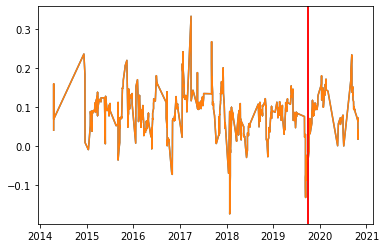

All Data
0.5434892717584172


2 topics with a coherence value of 0.5434892717584172
Positive topics with a probability of >0.5:
1  :  0.5532326072454452
Negative topics with a probability of >0.5:
0  :  0.5461552755700217
0: 0.001*"fractie" + 0.001*"plekken" + 0.001*"redenen" + 0.001*"afbouwen" + 0.001*"verbetering" + 0.001*"slot" + 0.001*"wijken" + 0.001*"viel" + 0.001*"sociale" + 0.001*"toekomstige" + 0.001*"komt" + 0.001*"locaties" + 0.001*"grote" + 0.001*"grashoff" + 0.001*"auto" + 0.001*"tijd" + 0.001*"bijdrage" + 0.001*"zorg" + 0.001*"geld" + 0.001*"duur"

1: 0.001*"grashoff" + 0.001*"cijfers" + 0.001*"komt" + 0.001*"snel" + 0.001*"ervaringen" + 0.001*"nieuwe" + 0.001*"apparaat" + 0.001*"hoop" + 0.001*"wet" + 0.001*"zomer" + 0.001*"hinderbeperking" + 0.001*"fractie" + 0.001*"klaver" + 0.001*"vastleggen" + 0.001*"afbouwen" + 0.001*"km" + 0.001*"laat" + 0.001*"amsterdam" + 0.001*"ervoor" + 0.001*"positieve"



Before Covid
0.33809516679048185


6 topics with a coherence value of 0.

In [23]:
alles("VVD", "GroenLinks")
topic_checker("VVD", "GroenLinks")

## Evaluation <a id='chapter5' ></a>

The key in this notebook would be the sentiment analysis. The sentiment analysis is used from the pattern library as it has 6887 unique words annotated to be most descriptive about the utterances being made in the dutch parliament. The evaluation of this tool is done by the University of Twente using MAE or Mean Average Error. The scores they found where between a score of 0.501 and 0.607.

The polynomal regression function has built in that it uses the k parameter with the lowest Random Mean Squared Error. The function prints the k that has been found and the error score for this function. This is built in the function scince it is different for every party. For the parties we use in the results, the VVD and GroenLinks:

k = 7 with a RMSE of 0.18399967064250217

The LDA topic analysis has a built in function to find the highest topic coherence score. This coherence score is calculated by a tool from the Gensim library. This is a pipeline based on four stages namely: segmentation, probability estimation, confirmation measure, aggregation. Again this is built in because it differs between the parties. For the parties we use in the results, the VVD and GroenLinks:

<img src='Coh_LDA.png' width=400>

## Conclusion <a id='chapter6' ></a>



In the results we find that the sentiment analysis being used makes an accurate display of how humans would interperate an utterance compared to python NLP analysis. From this sentiment analysis and transformation of the data using a rolling window gives stability to data and successfully annotates the sentiment. Finding the topic behind the positive or negative sentiment with LDA shows us that the rolling window generalizes the utterances too much and causes the topics to have many of the same keywords. The rolling window is successful in showing overall sentiment between parties and filtering noise, but makes it harder to connect to specific topics. Using rule-based topic analysis the notebook still shows clear results based on percentages within the utterances. This implementations could be of better use when analyzing a small amount of topics with a lot of utterances. 

## Discussion <a id='chapter7'></a>

First of all the rolling window has parameters that are open for discussion on which to use. The parameters are the way the window calculates the different datapoints to one and the time space per datapoint is to be specified. In this notebook there is chosen to use mean and thirty days. This is done because the research aimed to find descriptive periods of time and filter out sentiment differences based on sarcasm or other miss interpetation of pattern. It was also a method of choice because when plotted, the research saw some underlying line of utterances being higher in average or lower in certain times. With this rolling window the notebook may generalize too much and is not very usable for LDA. It could be in future works that the LDA would preform better when using raw sentiment values from the utterances.  

The LDA tool by Gensim was not used with altering all the possible parameters. With a grid search, or some optimizing method, these could cause higher coherence values between the topics. Therefore it is important for future works to include these parameters.

At last there is the way that the baseline is appointed to the rule-based topic analysis. In this manner the baseline is set as a percentage where the negative and positive notions are compared as percentages as well. For future work it may be interesting to see if another type of baseline can give a more clear view of the amount of notions.

## Literature

Kanayama, H., Nasukawa, T., & Watanabe, H. (2004). Deeper sentiment analysis using machine translation technology. In COLING 2004: Proceedings of the 20th International Conference on Computational Linguistics (pp. 494-500).

Song, Y., Pan, S., Liu, S., Zhou, M. X., & Qian, W. (2009, November). Topic and keyword re-ranking for LDA-based topic modeling. In Proceedings of the 18th ACM conference on Information and knowledge management (pp. 1757-1760).